In [78]:
import os
import glob
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from audio_processing import AudioProcessor
import librosa
import librosa.display


INPUT_FILE = '../data/cleaned/80_20_cleaned_train.parquet'
INPUT_AUDIO_DIR = '../data/raw/audio/xeno_canto'
OUTPUT_SPECTROGRAM_DIR = '../data/processed/spectrograms/xeno_canto'
OUTPUT_FEATURE_DIR = '../data/processed/features/xeno_canto'
TARGET_RECORDINGS = 100


os.makedirs(OUTPUT_SPECTROGRAM_DIR, exist_ok=True)
os.makedirs(OUTPUT_FEATURE_DIR, exist_ok=True)

df = pd.read_parquet(INPUT_FILE)
species_counts = df['en'].value_counts()

In [79]:
from pydub import AudioSegment
import librosa
import soundfile as sf
import os
from tqdm import tqdm
import glob

OUTPUT_AUDIO_DIR = '../data/TEST'
os.makedirs(OUTPUT_AUDIO_DIR, exist_ok=True)
ap = AudioProcessor(sample_rate=16000, segment_duration=30, target_db_level=-15, seed=42)

for _, row in tqdm(df.iloc[[19]].iterrows(), total=len(df)):
    audio_id = row['id']
    species_name = row['en']
    audio_files = glob.glob(os.path.join(INPUT_AUDIO_DIR, f"{audio_id}.*"))
    audio_path = audio_files[0]

    y, sr = librosa.load(audio_path, sr=None)

    original_save_path = os.path.join(OUTPUT_AUDIO_DIR, f"{audio_id}_original.mp3")
    sf.write(original_save_path, y, sr, format='mp3')

    if sr != 16000:
        y = librosa.resample(y, orig_sr=sr, target_sr=16000)
        resampled_save_path = os.path.join(OUTPUT_AUDIO_DIR, f"{audio_id}_resampled.mp3")
        sf.write(resampled_save_path, y, 16000, format='mp3')
    
    y_trimmed, _ = librosa.effects.trim(y, top_db=20)
    trimsilence_save_path = os.path.join(OUTPUT_AUDIO_DIR, f"{audio_id}_trimsilence.mp3")
    sf.write(trimsilence_save_path, y_trimmed, 16000, format='mp3')
    
    y_spectral_gating = ap.spectral_gating(y_trimmed, 13, 5000)
    spectral_gating_save_path = os.path.join(OUTPUT_AUDIO_DIR, f"{audio_id}_spectral_gating.mp3")
    sf.write(spectral_gating_save_path, y_spectral_gating, 16000, format='mp3')

    y_normalized = ap.normalize_audio(y_spectral_gating)
    spectral_gating_save_path = os.path.join(OUTPUT_AUDIO_DIR, f"{audio_id}_normalized.mp3")
    sf.write(spectral_gating_save_path, y_normalized, 16000, format='mp3')

    target_length = 30 * 16000
    if len(y) > target_length:
        # Trim the audio
        trimm_length_save_path = os.path.join(OUTPUT_AUDIO_DIR, f"{audio_id}_trimm_length.mp3")
        sf.write(trimm_length_save_path, y_normalized[:target_length], 16000, format='mp3')
        y = y_normalized[:target_length]
    elif len(y) < target_length:
        # Repeat the audio to reach the target length
        num_repeats = target_length // len(y)
        remainder = target_length % len(y)
        padd_length_save_path = os.path.join(OUTPUT_AUDIO_DIR, f"{audio_id}_padd_length.mp3")
        sf.write(padd_length_save_path, np.concatenate([y_normalized] * num_repeats + [y_normalized[:remainder]]), 16000, format='mp3')
        y = np.concatenate([y_normalized] * num_repeats + [y_normalized[:remainder]])
    else:
        same_length_save_path = os.path.join(OUTPUT_AUDIO_DIR, f"{audio_id}_same_length.mp3")
        sf.write(same_length_save_path, y_normalized, 16000, format='mp3')
        y = y_normalized
        

    logmel_save_path = os.path.join(OUTPUT_AUDIO_DIR, f"{audio_id}_logmel_length.mp3")
    n_fft = int(0.025 * sr)  
    hop_length = int(0.01 * sr)  
    n_mels = 80
    S_db = ap.create_log_mel_spectrogram(y, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    S_reconstructed = librosa.db_to_power(S_db, ref=1.0)
    y_reconstructed = librosa.feature.inverse.mel_to_audio(
        S_reconstructed,
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        power=1.0,
        n_iter=32,  
    )
    sf.write(logmel_save_path, y_reconstructed, sr)

  0%|          | 1/66148 [00:00<17:54:18,  1.03it/s]


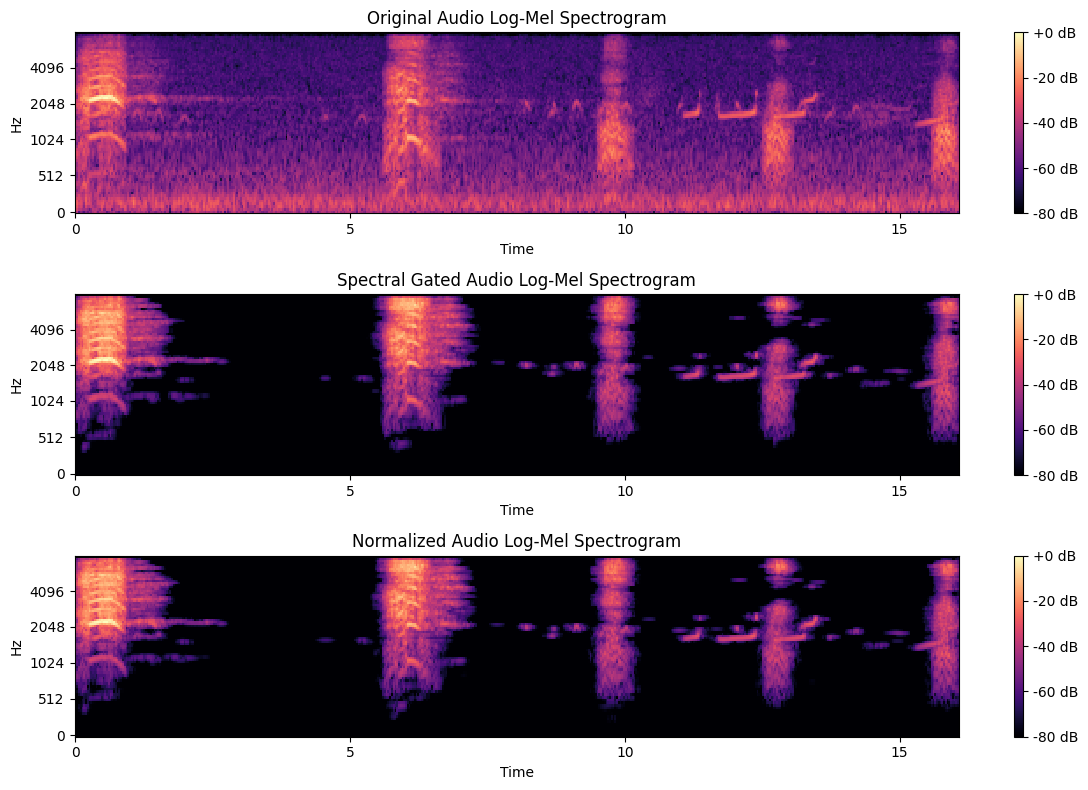

In [80]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

original_audio_path = os.path.join(OUTPUT_AUDIO_DIR, f"{audio_id}_trimsilence.mp3")
spectral_gated_audio_path = os.path.join(OUTPUT_AUDIO_DIR, f"{audio_id}_spectral_gating.mp3")
normalized_audio_path = os.path.join(OUTPUT_AUDIO_DIR, f"{audio_id}_normalized.mp3")

y_original, sr_original = librosa.load(original_audio_path, sr=16000)
y_spectral_gated, sr_spectral_gated = librosa.load(spectral_gated_audio_path, sr=16000)
y_normalized, sr_normalized = librosa.load(normalized_audio_path, sr=16000)


n_mels = 80  
n_fft = 400
hop_length = 160

mel_original = librosa.feature.melspectrogram(y=y_original, sr=sr_original, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
mel_db_original = librosa.power_to_db(mel_original, ref=np.max)

mel_spectral_gated = librosa.feature.melspectrogram(y=y_spectral_gated, sr=sr_spectral_gated, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
mel_db_spectral_gated = librosa.power_to_db(mel_spectral_gated, ref=np.max)

mel_normalized = librosa.feature.melspectrogram(y=y_normalized, sr=sr_normalized, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
mel_db_normalized = librosa.power_to_db(mel_normalized, ref=np.max)


plt.figure(figsize=(12, 8))


plt.subplot(3, 1, 1)
librosa.display.specshow(mel_db_original, sr=sr_original, hop_length=512, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Original Audio Log-Mel Spectrogram')

plt.subplot(3, 1, 2)
librosa.display.specshow(mel_db_spectral_gated, sr=sr_spectral_gated, hop_length=512, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectral Gated Audio Log-Mel Spectrogram')

plt.subplot(3, 1, 3)
librosa.display.specshow(mel_db_normalized, sr=sr_normalized, hop_length=512, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Normalized Audio Log-Mel Spectrogram')

plt.tight_layout()
plt.show()
